In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from distutils.dir_util import copy_tree, remove_tree
from random import randint
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_addons as tfa
import keras
from keras.layers import Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator as IDG
import cv2
import keras
import pydot
from keras.utils import plot_model


c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
base='./data2/'
# root_dir='./'
test=base+"test/"
train=base+"train/"
wdr="./dataset4/"
# if os.path.exists(wdr):
#     remove_tree(wdr)
# os.mkdir(wdr)
# copy_tree(train,wdr)
# copy_tree(test,wdr)
print("wdc:",os.listdir(wdr))

wdc: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
work='./dataset4/'
classes=['glioma', 'meningioma', 'notumor', 'pituitary']
idm=176
ida=[176,208]
DIM=(idm,idm)

In [4]:
train_data_gen = IDG(rescale=1./255)
# train_data_gen=train_data_gen.flow_from_directory(directory=work,target_size=DIM,batch_size=6500)
train_data_gen = train_data_gen.flow_from_directory(directory=work, target_size=DIM, batch_size=10185) #12 for more good res

Found 10185 images belonging to 4 classes.


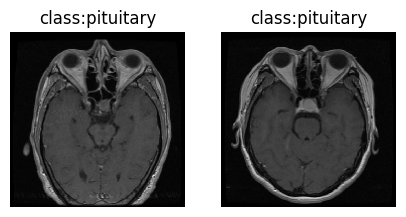

In [5]:
def show_images(generator):
    labels=dict(zip([0,1,2,3],classes))
    x,y=generator.next()
    plt.figure(figsize=(5,5))
    for i in range(2):
        ax=plt.subplot(2,2,i+1)
        idx=randint(0,3)
        plt.imshow(x[idx])
        plt.axis("off")
        plt.title("class:{}".format(labels[np.argmax(y[idx])]))

show_images(train_data_gen)

In [6]:
train_data,train_labels=train_data_gen.next()

In [7]:
sm=SMOTE(random_state=42)
train_data,train_labels=sm.fit_resample(train_data.reshape(-1,idm*idm*3),train_labels)
train_data=train_data.reshape(-1,idm,idm,3)
print(train_data.shape,train_labels.shape)

(10636, 176, 176, 3) (10636, 4)


In [8]:
train_data,test_data,train_labels,test_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)
train_data,val_data,train_labels,val_labels=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

In [9]:
incmodel=InceptionResNetV2(input_shape=(176,176,3),include_top=False,weights="imagenet")
for layer in incmodel.layers:
    layer.trainable=False
incmodel.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 87, 87, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 87, 87, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 87, 87, 32)           0         ['batch_norm

In [10]:
custommodel=tf.keras.Sequential([incmodel,Dropout(0.10),
                            GlobalAveragePooling2D(),Flatten(),
                            BatchNormalization(),
                            Dense(512,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(256,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(128,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(64,activation='relu'),
                            BatchNormalization(),
                            Dropout(0.10),
                            Dense(4,activation='softmax'),
                            ],name="inception_cnn_model")

In [11]:
METRICS=[tf.keras.metrics.CategoricalAccuracy(name='train_acc'),
         tf.keras.metrics.AUC(name='val_acc'),
         tfa.metrics.F1Score(num_classes=4)]
custommodel.compile(loss=tf.losses.CategoricalCrossentropy(),metrics=METRICS)
custommodel.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 4, 4, 1536)        54336736  
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 4, 4, 1536)        0         
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 batch_normalization_203 (B  (None, 1536)              6144      
 atchNormalization)                                              
                                               

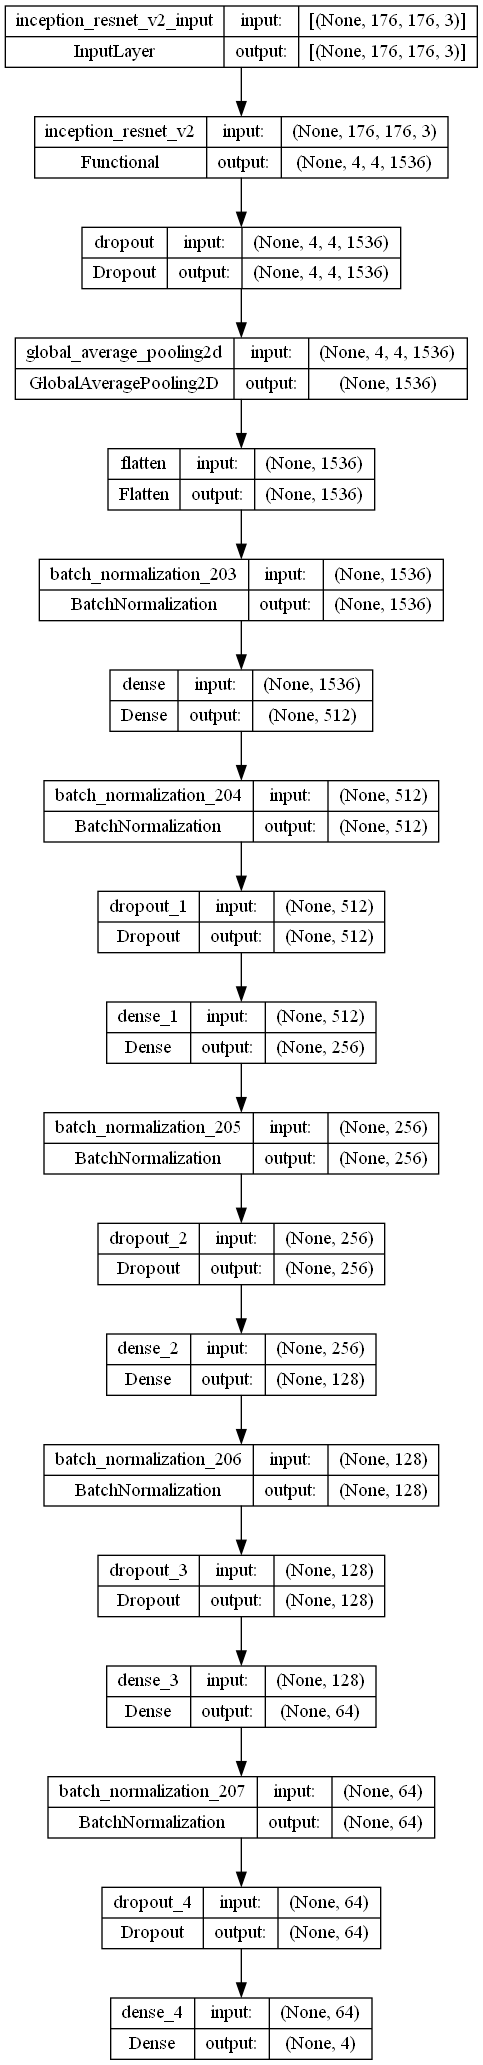

In [12]:
plot_model(custommodel, show_shapes=True)

In [14]:
EPOCHS = 2
history = custommodel.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=EPOCHS)

Epoch 1/2
213/213 [==============================] - 871s 4s/step - loss: 0.3997 - train_acc: 0.8670 - val_acc: 0.9709 - f1_score: 0.8670 - val_loss: 1.5031 - val_train_acc: 0.6340 - val_val_acc: 0.8678 - val_f1_score: 0.5749
Epoch 2/2
213/213 [==============================] - 864s 4s/step - loss: 0.2138 - train_acc: 0.9293 - val_acc: 0.9903 - f1_score: 0.9295 - val_loss: 1.9570 - val_train_acc: 0.7521 - val_val_acc: 0.8881 - val_f1_score: 0.7510


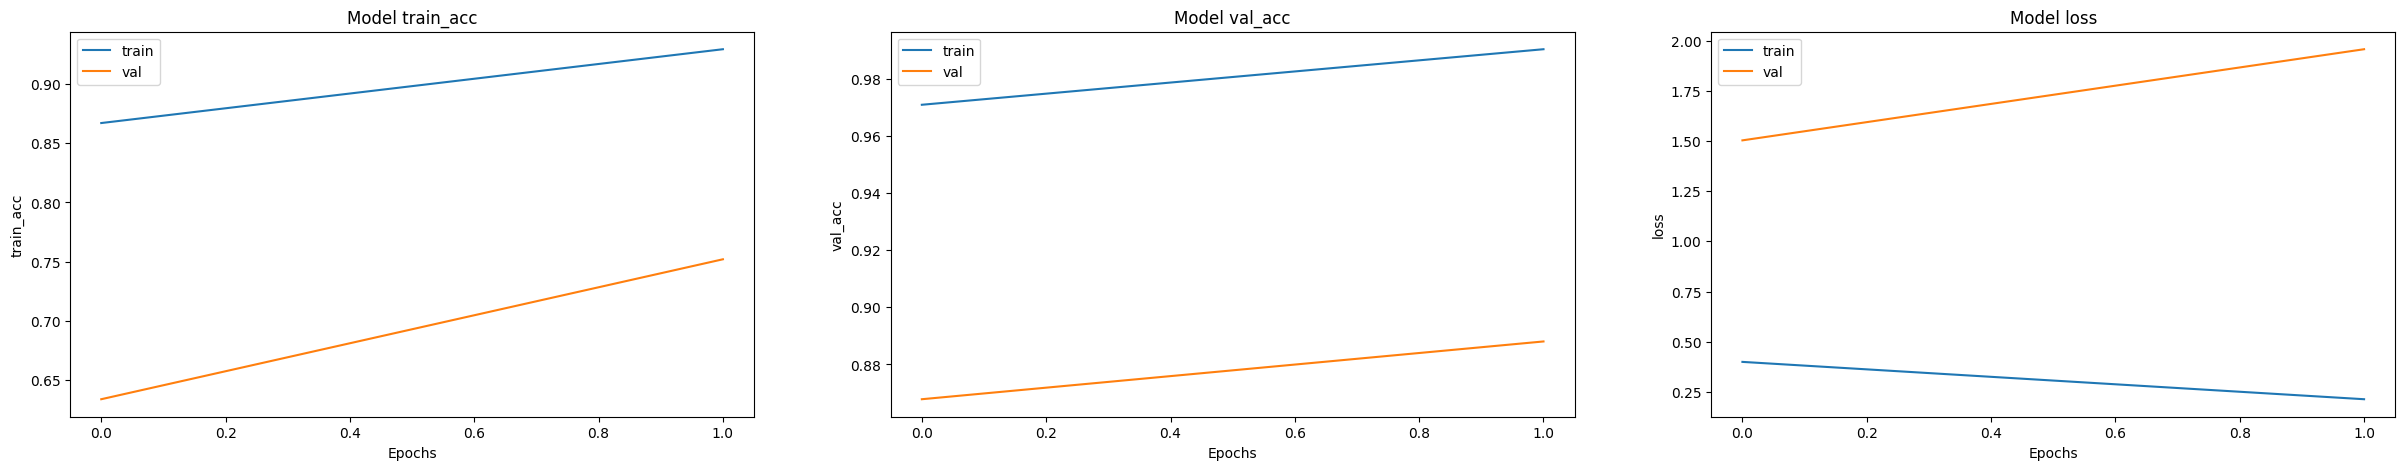

In [15]:
fig ,ax=plt.subplots(1,3,figsize=(30,5))
ax=ax.ravel()
for i,metric in enumerate(["train_acc","val_acc","loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_"+metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train","val"])

In [16]:
test_scores=custommodel.evaluate(test_data,test_labels)
print("Loss: ", test_scores[0])
print("Accuracy: ", test_scores[1])

67/67 [==============================] - 56s 827ms/step - loss: 1.8901 - train_acc: 0.7439 - val_acc: 0.8879 - f1_score: 0.7486
Loss:  1.890098214149475
Accuracy:  0.7438910007476807


In [17]:
pred_labels=custommodel.predict(test_data)

67/67 [==============================] - 58s 832ms/step


In [18]:
def roundoff(arr):
    arr[np.argwhere(arr!=arr.max())]=0
    arr[np.argwhere(arr==arr.max())]=1
    return arr
for labels in pred_labels:
    labels=roundoff(labels)
print(classification_report(test_labels,pred_labels,target_names=classes))

              precision    recall  f1-score   support

      glioma       0.99      0.64      0.78       528
  meningioma       0.55      0.89      0.68       541
     notumor       0.97      0.56      0.71       548
   pituitary       0.77      0.89      0.82       511

   micro avg       0.74      0.74      0.74      2128
   macro avg       0.82      0.75      0.75      2128
weighted avg       0.82      0.74      0.75      2128
 samples avg       0.74      0.74      0.74      2128



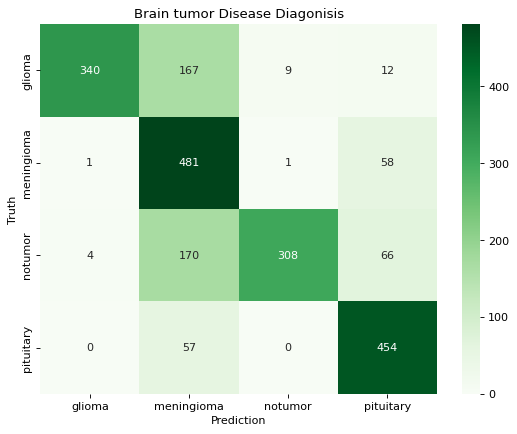

In [19]:
pred_ls=np.argmax(pred_labels,axis=1)
test_ls=np.argmax(test_labels,axis=1)
conf_arr=confusion_matrix(test_ls,pred_ls)
plt.figure(figsize=(8,6),dpi=80,facecolor='w',edgecolor='k')
ax=sns.heatmap(conf_arr,cmap='Greens',annot=True,fmt='d',xticklabels=classes,yticklabels=classes)
plt.title('Brain tumor Disease Diagonisis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [20]:
print('Balanced Accuracy score {}%'.format(round(BAS(test_ls,pred_ls)*100,2)))
print('Matthews Correleation Corrcoef {}%'.format(round(MCC(test_ls,pred_ls)*100,2)))

Balanced Accuracy score 74.59%
Matthews Correleation Corrcoef 67.93%


In [21]:
custom_incmodel_dir=wdr+"BT_CNN_model_t1"
custommodel.save(custom_incmodel_dir,save_format='h5')
os.listdir(wdr)

c:\Users\Jaswanth\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['BT_CNN_model_t1', 'glioma', 'meningioma', 'notumor', 'pituitary']

In [22]:
ci=['glioma','meningioma','no-tumor','pituitary']
# Load the image
image = cv2.imread('./testim1.jpg')

# Resize the image to match the expected input shape
image = cv2.resize(image, (176, 176))

# Normalize the image
image = image / 255.0

# Add an extra dimension to the image
image = np.expand_dims(image, axis=0)

# Load the model
model = keras.models.load_model('./dataset4/BT_CNN_model_t1')

# Predict the class probabilities of the image
prediction = model.predict(image)

# Get the index of the class with the highest probability
pci = np.argmax(prediction[0])

# Display the result
print(prediction[0])
print('The predicted class is:', ci[pci])


ValueError: Unknown layer: 'CustomScaleLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
# import cv2
# import numpy as np

# # Load the image using cv2
# image = cv2.imread('Te-pi_0116.jpg')

# # Convert the image to a matrix array
# image_array = np.array(image)

# # Save the array to a file
# np.save('image_array.npy', image_array)


In [ ]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # Load the array from the .npy file
# image_array = np.load('image_array.npy')

# # Reconstruct the image using cv2
# reconstructed_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)

# # Display the reconstructed image
# plt.imshow(reconstructed_image)
# plt.axis('off')
# plt.show()

# # Alternatively, save the reconstructed image
# cv2.imwrite('reconstructed_image.jpg', reconstructed_image);
